# Libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import copy
#import torchsummary
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
cudnn.benchmark = True
plt.ion()   # interactive mode

selected_gpu = 1 # here you select the GPU used (0, 1 or 2)
device = torch.device("cuda:" + str(selected_gpu) if
torch.cuda.is_available() else "cpu")
print(f'the device is {device}')


the device is cuda:1


In [2]:
#if running locally
notebook_path = Path().cwd()
#if running in colab
#notebook_path = Path('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte/Deep_Learning/notebooks')

project_path = notebook_path.parent
repo_path = project_path.parent
os.chdir(notebook_path)
print(f'The current directory is {Path().cwd()}')

The current directory is /home/user7/skin_lesion_classification/Deep_Learning/notebooks


Prepare data
- This includes:
    - Preprocessing the data
    - Define datasets dictiornaries with paths, classes, etc.
    - Define the data loaders

In [3]:
image_size = 120
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#directory with images
data_dir = repo_path /'Machine_Learning'/'images' / 'binary'
#define dictionary containing the train and validation image folder objects
#it contains the image paths, as well as the class and other atirbutes.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
#define dictionary containing the train and validation data loaders
#This is taking the image folder object, the batch size, and shuffling the images.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
#define dictionary with the train and validation dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#get classes names
class_names = image_datasets['train'].classes

We look at some images to see if they are fine

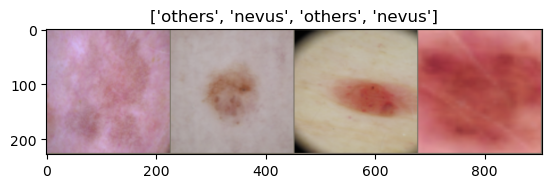

In [4]:
def imshow(input:torch.Tensor, title=None):
    """shows a preprocessed tensor in its original form

    Args:
        input (torch.Tensor): input tensor
        title (_type_, optional): _description_. Defaults to None.
    """
    #get numpy, and put color at the end
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #scale back
    input = std * input + mean
    input = np.clip(input, 0, 1)
    
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

We define the trainning function

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #training starting time
    since = time.time()
    #deep copy of the model's state dicitonary (the weights)
    best_model_wts = copy.deepcopy(model.state_dict())
    #save accuracy variable
    best_acc = 0.0

    for epoch in range(num_epochs): #go thorugh all epochs
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        #After finishing training with one epoch, the validation set is used to check performance.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            #reset loss and accuracy variables
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                #send inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # FORWARD step
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #get model outputs
                    outputs = model(inputs)
                    #????
                    _, preds = torch.max(outputs, 1)
                    #compute loss
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # store statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     #change learning rate according to the scheduler
            #     scheduler.step()
            #get epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #print the phase loss and accuracy
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if the epoch validation accuracy is the highest
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                #save the model
                torch.save(model.state_dict(), project_path / 'data'/ 'models'/ f'resnet18_epoch{epoch}_adam.pt')
    
    #after all epochs, print the total training time, and the best validation accuracy
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

With everything defined we can now load the model

In [7]:
#load pretrained model
model = models.resnet18(weights='DEFAULT')
#check model architecture
#torchsummary.summary(model, (3, 224, 224))
#check number of features extracted before the last FC layer
num_features = model.fc.in_features
#change number of outputs from FCL to 2
model.fc = nn.Linear(num_features, 2)
#send model to device
model = model.to(device)
#define loss function
criterion = nn.CrossEntropyLoss()
#define optimizer as Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)
#define scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
model = train_model(model, criterion, optimizer, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


100%|██████████| 3799/3799 [02:39<00:00, 23.83it/s]


train Loss: 0.6387 Acc: 0.6588


100%|██████████| 949/949 [00:23<00:00, 40.82it/s]


val Loss: 0.5752 Acc: 0.6802
Epoch 1/24
----------


100%|██████████| 3799/3799 [02:25<00:00, 26.06it/s]


train Loss: 0.5674 Acc: 0.7033


100%|██████████| 949/949 [00:20<00:00, 45.36it/s]


val Loss: 0.5118 Acc: 0.7463
Epoch 2/24
----------


100%|██████████| 3799/3799 [02:25<00:00, 26.12it/s]


train Loss: 0.5270 Acc: 0.7354


100%|██████████| 949/949 [00:22<00:00, 42.85it/s]


val Loss: 0.4875 Acc: 0.7650
Epoch 3/24
----------


100%|██████████| 3799/3799 [02:26<00:00, 25.97it/s]


train Loss: 0.5085 Acc: 0.7483


100%|██████████| 949/949 [00:22<00:00, 43.02it/s]


val Loss: 0.5279 Acc: 0.7650
Epoch 4/24
----------


100%|██████████| 3799/3799 [02:20<00:00, 26.99it/s]


train Loss: 0.4989 Acc: 0.7528


100%|██████████| 949/949 [00:26<00:00, 35.51it/s]


val Loss: 0.4806 Acc: 0.7829
Epoch 5/24
----------


100%|██████████| 3799/3799 [02:19<00:00, 27.28it/s]


train Loss: 0.4882 Acc: 0.7646


100%|██████████| 949/949 [00:22<00:00, 42.01it/s]


val Loss: 0.8407 Acc: 0.7476
Epoch 6/24
----------


100%|██████████| 3799/3799 [02:20<00:00, 27.01it/s]


train Loss: 0.4811 Acc: 0.7669


100%|██████████| 949/949 [00:26<00:00, 36.40it/s]


val Loss: 0.4994 Acc: 0.7774
Epoch 7/24
----------


100%|██████████| 3799/3799 [02:23<00:00, 26.49it/s]


train Loss: 0.4771 Acc: 0.7701


100%|██████████| 949/949 [00:20<00:00, 45.99it/s]


val Loss: 0.4898 Acc: 0.7742
Epoch 8/24
----------


100%|██████████| 3799/3799 [02:21<00:00, 26.78it/s]


train Loss: 0.4707 Acc: 0.7742


100%|██████████| 949/949 [00:24<00:00, 39.19it/s]


val Loss: 1.3818 Acc: 0.7326
Epoch 9/24
----------


100%|██████████| 3799/3799 [02:24<00:00, 26.24it/s]


train Loss: 0.4707 Acc: 0.7726


100%|██████████| 949/949 [00:21<00:00, 44.24it/s]


val Loss: 0.4888 Acc: 0.7732
Epoch 10/24
----------


 47%|████▋     | 1769/3799 [01:05<01:15, 26.89it/s]


KeyboardInterrupt: 

# Tunning only the last layer
- We can also use this network pre-trained weights and only train the last layer
- Beginning of a feature extractor idea
    - Instead of the last FCL we could use a ML binary classifier like SVM.

In [11]:
#charge model
model_fext = models.resnet18(weights='DEFAULT')
#block the gradiant tracing for the parameters (weights)
for param in model_fext.parameters():
    param.requires_grad = False

#again, redefine last layer to our binary problem
num_ftrs = model_fext.fc.in_features
model_fext.fc = nn.Linear(num_ftrs, 2)
model_fext = model_fext.to(device)
#define 
criterion = nn.CrossEntropyLoss()

optimizer_fext = optim.SGD(model_fext.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler_fext = lr_scheduler.StepLR(optimizer_fext, step_size=7, gamma=0.1)

Train last layer only

In [12]:
model_conv = train_model(model_fext, criterion, optimizer_fext,
                         lr_scheduler_fext, num_epochs=25)

Epoch 0/24
----------


100%|██████████| 3799/3799 [02:03<00:00, 30.86it/s]


train Loss: 0.7180 Acc: 0.6804


100%|██████████| 949/949 [00:30<00:00, 30.89it/s]


val Loss: 0.6918 Acc: 0.7063
Epoch 1/24
----------


100%|██████████| 3799/3799 [02:00<00:00, 31.53it/s]


train Loss: 0.7393 Acc: 0.6770


100%|██████████| 949/949 [00:29<00:00, 32.07it/s]


val Loss: 0.6774 Acc: 0.7229
Epoch 2/24
----------


100%|██████████| 3799/3799 [01:59<00:00, 31.68it/s]


train Loss: 0.7151 Acc: 0.6848


100%|██████████| 949/949 [00:31<00:00, 30.61it/s]


val Loss: 0.5534 Acc: 0.7711
Epoch 3/24
----------


100%|██████████| 3799/3799 [02:02<00:00, 30.98it/s]


train Loss: 0.7579 Acc: 0.6767


100%|██████████| 949/949 [00:31<00:00, 30.14it/s]


val Loss: 1.2281 Acc: 0.6241
Epoch 4/24
----------


100%|██████████| 3799/3799 [02:02<00:00, 31.08it/s]


train Loss: 0.7252 Acc: 0.6768


100%|██████████| 949/949 [00:32<00:00, 29.23it/s]


val Loss: 0.5619 Acc: 0.7595
Epoch 5/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.15it/s]


train Loss: 0.7072 Acc: 0.6856


100%|██████████| 949/949 [00:30<00:00, 30.77it/s]


val Loss: 0.8225 Acc: 0.6799
Epoch 6/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.22it/s]


train Loss: 0.7105 Acc: 0.6898


100%|██████████| 949/949 [00:31<00:00, 30.49it/s]


val Loss: 0.6398 Acc: 0.7316
Epoch 7/24
----------


100%|██████████| 3799/3799 [01:59<00:00, 31.79it/s]


train Loss: 0.5614 Acc: 0.7229


100%|██████████| 949/949 [00:31<00:00, 30.55it/s]


val Loss: 0.5085 Acc: 0.7624
Epoch 8/24
----------


100%|██████████| 3799/3799 [02:03<00:00, 30.87it/s]


train Loss: 0.5503 Acc: 0.7248


100%|██████████| 949/949 [00:32<00:00, 29.61it/s]


val Loss: 0.5017 Acc: 0.7611
Epoch 9/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.29it/s]


train Loss: 0.5501 Acc: 0.7256


100%|██████████| 949/949 [00:30<00:00, 30.68it/s]


val Loss: 0.4852 Acc: 0.7719
Epoch 10/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.25it/s]


train Loss: 0.5490 Acc: 0.7217


100%|██████████| 949/949 [00:30<00:00, 31.37it/s]


val Loss: 0.4848 Acc: 0.7679
Epoch 11/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.34it/s]


train Loss: 0.5444 Acc: 0.7313


100%|██████████| 949/949 [00:31<00:00, 30.41it/s]


val Loss: 0.4971 Acc: 0.7637
Epoch 12/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.37it/s]


train Loss: 0.5490 Acc: 0.7252


100%|██████████| 949/949 [00:30<00:00, 31.16it/s]


val Loss: 0.4724 Acc: 0.7766
Epoch 13/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.37it/s]


train Loss: 0.5395 Acc: 0.7316


100%|██████████| 949/949 [00:32<00:00, 29.63it/s]


val Loss: 0.5698 Acc: 0.7226
Epoch 14/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.30it/s]


train Loss: 0.5326 Acc: 0.7372


100%|██████████| 949/949 [00:30<00:00, 31.11it/s]


val Loss: 0.5172 Acc: 0.7521
Epoch 15/24
----------


100%|██████████| 3799/3799 [02:00<00:00, 31.62it/s]


train Loss: 0.5247 Acc: 0.7380


100%|██████████| 949/949 [00:30<00:00, 31.07it/s]


val Loss: 0.4926 Acc: 0.7663
Epoch 16/24
----------


100%|██████████| 3799/3799 [02:00<00:00, 31.53it/s]


train Loss: 0.5315 Acc: 0.7341


100%|██████████| 949/949 [00:30<00:00, 31.62it/s]


val Loss: 0.5251 Acc: 0.7466
Epoch 17/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.16it/s]


train Loss: 0.5314 Acc: 0.7374


100%|██████████| 949/949 [00:31<00:00, 30.55it/s]


val Loss: 0.4924 Acc: 0.7619
Epoch 18/24
----------


100%|██████████| 3799/3799 [02:02<00:00, 30.95it/s]


train Loss: 0.5298 Acc: 0.7351


100%|██████████| 949/949 [00:30<00:00, 31.53it/s]


val Loss: 0.4698 Acc: 0.7792
Epoch 19/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.39it/s]


train Loss: 0.5289 Acc: 0.7371


100%|██████████| 949/949 [00:30<00:00, 31.47it/s]


val Loss: 0.4781 Acc: 0.7727
Epoch 20/24
----------


100%|██████████| 3799/3799 [02:02<00:00, 30.94it/s]


train Loss: 0.5295 Acc: 0.7361


100%|██████████| 949/949 [00:30<00:00, 30.78it/s]


val Loss: 0.4996 Acc: 0.7619
Epoch 21/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.33it/s]


train Loss: 0.5329 Acc: 0.7329


100%|██████████| 949/949 [00:30<00:00, 30.81it/s]


val Loss: 0.5032 Acc: 0.7590
Epoch 22/24
----------


100%|██████████| 3799/3799 [02:02<00:00, 30.92it/s]


train Loss: 0.5301 Acc: 0.7349


100%|██████████| 949/949 [00:29<00:00, 31.64it/s]


val Loss: 0.5157 Acc: 0.7540
Epoch 23/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.17it/s]


train Loss: 0.5244 Acc: 0.7395


100%|██████████| 949/949 [00:30<00:00, 31.22it/s]


val Loss: 0.5048 Acc: 0.7621
Epoch 24/24
----------


100%|██████████| 3799/3799 [02:01<00:00, 31.17it/s]


train Loss: 0.5204 Acc: 0.7431


100%|██████████| 949/949 [00:30<00:00, 30.87it/s]

val Loss: 0.4970 Acc: 0.7655
Training complete in 63m 31s
Best val Acc: 0.779241 at epoch 18
